In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [2]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20
EXP_NAME = 'frequency_viz'
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 20
N_EPOCHS = 2000
RESULTS_PATH = 'results'

In [3]:


if datasetName == 'PAMAP2':
    dataset = DatasetPAMAP2(seconds = 4 , mode = 'leave-one-subject', signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3'])
    
elif datasetName ==  'HAR-UML20':
    dataset = DatasetHARUML20(mode = 'leave-one-subject')
    
CLASS_LABELS = dataset.activities
save_name = datasetName + '_' + EXP_NAME
saver = MetricsSaver(save_name, rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [4]:
dataset.loadData()

True

In [12]:
ts_train = TSerie(dataset.X_train, dataset.Int_train)
ts_test = TSerie(dataset.X_test, dataset.Int_test)

# ts_train.center()
# ts_test.center()

In [13]:
from scipy.fft import fft

def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:  
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='same')
    return y[window_len:-window_len+1]



ts_train.features =  np.linalg.norm(ts_train.X[:, :, :3], axis=2)
ts_test.features = np.linalg.norm(ts_test.X[:, :, :3], axis=2)

for i in range(ts_train.N):
    ts_train.features[i] = np.absolute(fft(ts_train.features[i]))
    # ts_train.features[i] = fft(ts_train.features[i])
    ts_train.features[i] = smooth(ts_train.features[i], window_len=50)
    # ts_train.features[i][ts_train.features[i] < 400] = 0
    
for i in range(ts_test.N):
    ts_test.features[i] = np.absolute(fft(ts_test.features[i]))
    ts_test.features[i] = smooth(ts_test.features[i], window_len=50)
    # ts_test.features[i][ts_test.features[i] < 400] = 0
    # ts_test.features[i] = fft(ts_test.features[i])

# ts_train.features = ts_train.features[:, 1:ts_train.T//2 + 1]
# ts_test.features = ts_test.features[:, 1:ts_train.T//2 + 1]

ts_train.features[:, 0] = 0
ts_test.features[:, 0] = 0


In [15]:
model = UMAP_FL(n_components=2,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='euclidean')
train_coords = model.fit_transform(ts_train.features, y=ts_train.y)
# train_coords = model.fit_transform(ts_train.features)
test_coords = model.transform(ts_test.features)

MemoryError: std::bad_alloc: CUDA error at: /home/texs/anaconda3/envs/rapidsml/include/rmm/mr/device/cuda_memory_resource.hpp:69: cudaErrorUnknown unknown error

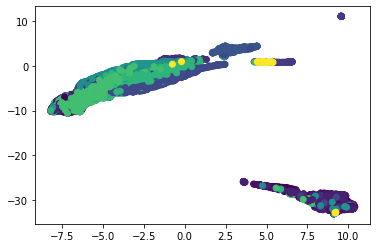

In [8]:
import matplotlib.pyplot as plt
# import seaborn as sns

plt.scatter(train_coords[:,0], train_coords[:,1], c=ts_train.y)

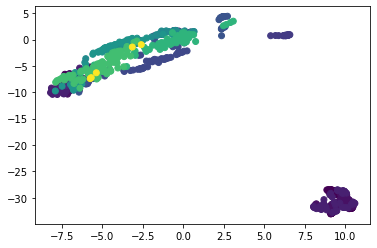

In [9]:
import matplotlib.pyplot as plt

plt.scatter(test_coords[:,0], test_coords[:,1], c=ts_test.y)

In [10]:
# ts_train.X.shape
# np.expand_dims(ts_train.features, axis = 2).shape
ts_train.X = np.concatenate([ts_train.X, np.expand_dims(ts_train.features, axis = 2)], axis =2)
ts_test.X = np.concatenate([ts_test.X, np.expand_dims(ts_test.features, axis = 2)], axis =2)

In [11]:
# import sys
# sys.path.insert(0, '/home/texs/Documentos/Repositories/mts_viz')

from server.source.storage import MTSStorage

storage = MTSStorage('frequency_visualizations')
storage.load()

# activities_map = {act: str(act) for act in np.unique(y)}
storage.add_mts(
    'train',  ts_train.X,
    # ts_train.
    np.append(dataset.signals, 'freq'),
    coords={'umap': train_coords}, 
    labels={'activities': ts_train.y}, 
    labelsNames={'activities': dataset.activities_map},
    sampling = True,
    n_samples = 2000
)

storage.add_mts(
    'test', ts_test.X,
    np.append(dataset.signals, 'freq'),
    coords={'umap': test_coords}, 
    labels={'activities': ts_test.y}, 
    labelsNames={'activities': dataset.activities_map},
    sampling = True,
    n_samples = 2000
)
storage.save()

mts shape: N: 6174 -  T: 400 - D: 7
mts shape: N: 825 -  T: 400 - D: 7
